In [10]:
%%capture
!pip install torchinfo

In [25]:
import pandas as pd
import numpy as np
import plotly.express as px
import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from torch.optim import AdamW
from PIL import Image

# data preprocessing

In [12]:
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [13]:
# Hàm chia train/val
def split_train_val(data_dir, val_ratio=0.1):
    for class_name in os.listdir(data_dir):
        if class_name.lower() == 'disgust': continue  # Bỏ class disgust

        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir): continue

        images = os.listdir(class_dir)
        random.shuffle(images)

        val_count = int(len(images) * val_ratio)
        val_images = images[:val_count]

        val_class_dir = os.path.join('/kaggle/working/val', class_name)
        os.makedirs(val_class_dir, exist_ok=True)

        for img in val_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(val_class_dir, img)
            shutil.copy(src, dst)

# Thực hiện chia tập train/val
split_train_val('/kaggle/input/fer2013/train', val_ratio=0.1)

# Data augmentation cho tập train
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Transform cho val/test
test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(root='/kaggle/input/fer2013/train', transform=train_transform)
val_dataset   = datasets.ImageFolder(root='/kaggle/working/val', transform=test_transform)
test_dataset  = datasets.ImageFolder(root='/kaggle/input/fer2013/test', transform=test_transform)

# Hàm lọc bỏ disgust
def filter_disgust(dataset):
    disgust_idx = dataset.class_to_idx.get('disgust')
    if disgust_idx is None: return

    filtered_samples = [(path, label) for path, label in dataset.samples if label != disgust_idx]
    dataset.samples = filtered_samples
    dataset.targets = [label for _, label in dataset.samples]
    dataset.classes.remove('disgust')
    dataset.class_to_idx.pop('disgust')

# Áp dụng hàm lọc disgust
filter_disgust(train_dataset)
filter_disgust(val_dataset)
filter_disgust(test_dataset)
def reindex_labels(dataset):
    # Tạo lại class_to_idx theo thứ tự mới
    new_class_to_idx = {cls_name: idx for idx, cls_name in enumerate(dataset.classes)}
    dataset.class_to_idx = new_class_to_idx
    # Lấy nhãn mới dựa theo tên thư mục ảnh
    dataset.samples = [(path, new_class_to_idx[os.path.basename(os.path.dirname(path))]) for path, _ in dataset.samples]
    dataset.targets = [label for _, label in dataset.samples]


# Áp dụng cho tất cả các dataset sau khi loại bỏ disgust
reindex_labels(train_dataset)
reindex_labels(val_dataset)
reindex_labels(test_dataset)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('Classes:', train_dataset.classes)

Classes: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


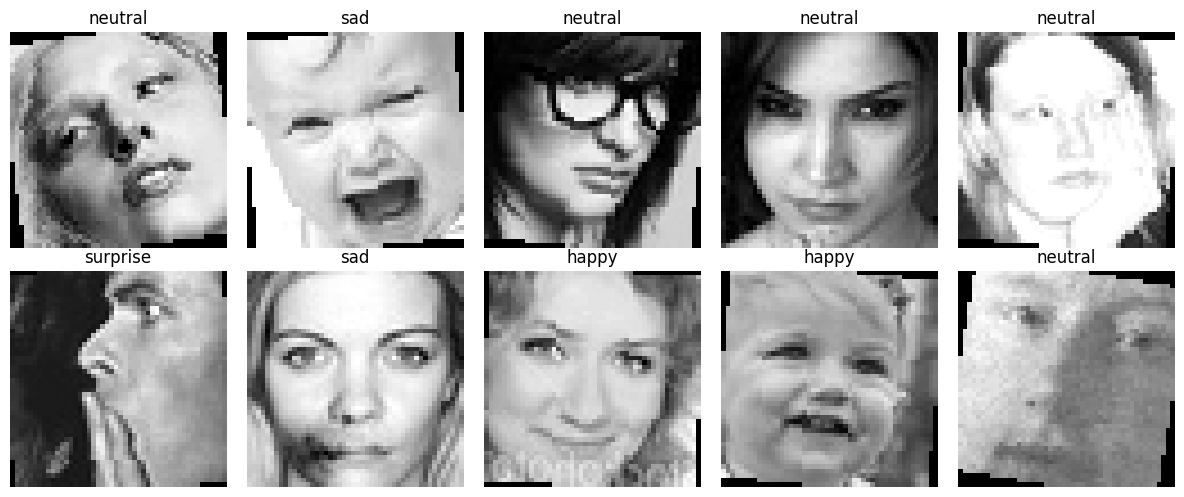

In [ ]:
# Hiển thị data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Lấy đúng class theo targets gốc từ dataset
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

plt.figure(figsize=(12, 5))
for i in range(10):
    img = images[i].permute(1, 2, 0).squeeze()
    label = idx_to_class[labels[i].item()]

    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


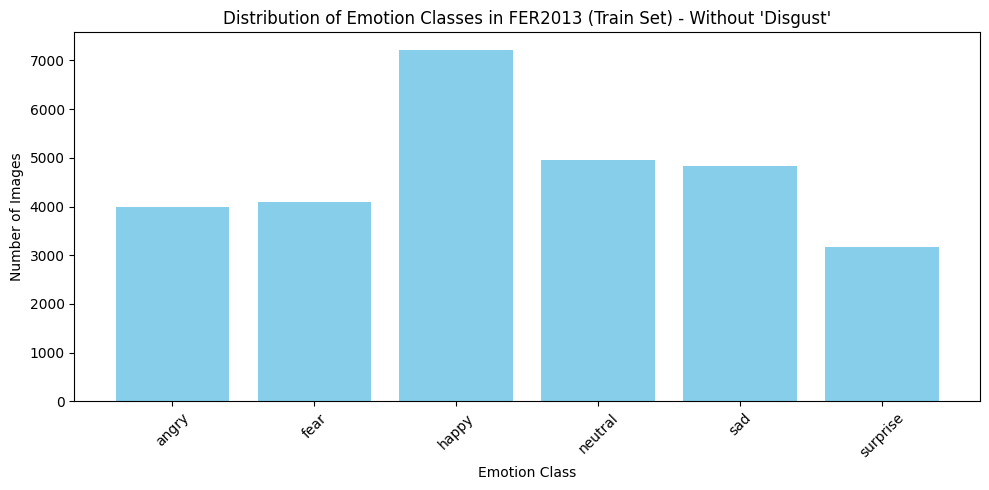

In [5]:
# Biểu đồ xem sự phẩn bổ dữ liệu giữa các class
data_dir = '/kaggle/input/fer2013/train'

# Bỏ qua class 'disgust'
class_counts = {}
for class_name in os.listdir(data_dir):
    if class_name.lower() == 'disgust':
        continue  # Loại bỏ disgust
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count

class_counts = dict(sorted(class_counts.items()))

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Emotion Class")
plt.ylabel("Number of Images")
plt.title("Distribution of Emotion Classes in FER2013 (Train Set) - Without 'Disgust'")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Tính trọng số các lớp còn lại
# Mapping các class còn lại (đã bỏ disgust)
class_labels = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Tính toán trọng số cho các class còn lại
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_labels),
    y=[label for label, count in class_counts.items() for _ in range(count)]
)

class_weights_dict = {label: weight for label, weight in zip(class_labels, class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {'angry': np.float64(1.1795160617438465), 'fear': np.float64(1.1501505166381905), 'happy': np.float64(0.6531069531069531), 'neutral': np.float64(0.9490768714333669), 'sad': np.float64(0.9756038647342995), 'surprise': np.float64(1.486019131714496)}


In [7]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 7)  # FER2013 có 7 lớp cảm xúc
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# model

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=5, device='cuda', scheduler=None, save_path='best_model.pt'):
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= total_train
        train_acc = correct_train / total_train

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= total_val
        val_acc = correct_val / total_val

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if scheduler:
            scheduler.step()

        # Early stopping + Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    model.load_state_dict(torch.load(save_path))
    print(f"✅ Loaded best model from {save_path}")
    return model

In [9]:
# Bước 1: Class weights cho 7 lớp (chèn 0.0 cho lớp 'disgust' nếu không có dữ liệu)
class_weights_dict = {
    'angry': 1.1795160617438465,
    'disgust': 1e-6,
    'fear': 1.1501505166381905,
    'happy': 0.6531069531069531,
    'sad': 0.9756038647342995,
    'surprise': 1.486019131714496,
    'neutral': 0.9490768714333669
}

# Chuyển class weights thành tensor đúng thứ tự lớp
class_order = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
class_weights = [class_weights_dict[cls] for cls in class_order]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Đưa lên thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = class_weights_tensor.to(device)

# Bước 2: Khởi tạo mô hình
model = EmotionCNN().to(device)

# Bước 3: Loss function có class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Bước 4: Optimizer và Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Bước 5: Huấn luyện mô hình
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=50,
    patience=5,
    device=device,
    scheduler=scheduler
)


KeyboardInterrupt: 

# evaluation

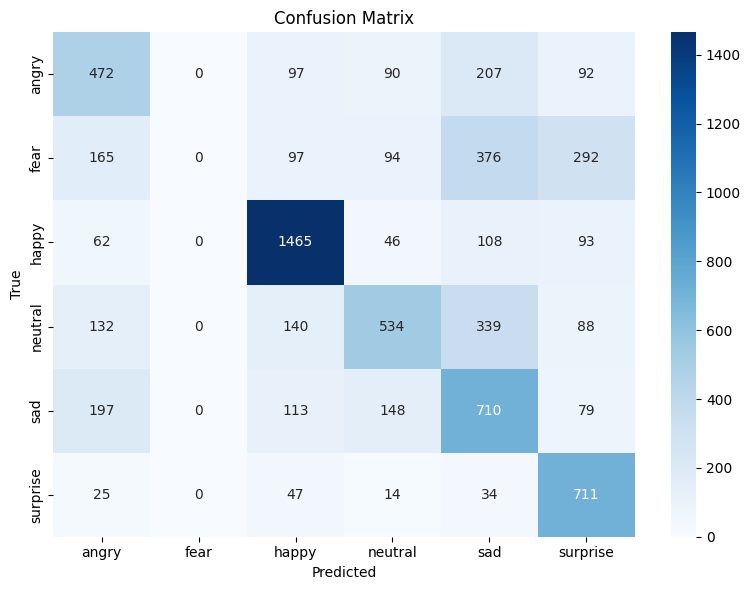

              precision    recall  f1-score   support

       angry       0.45      0.49      0.47       958
        fear       0.00      0.00      0.00      1024
       happy       0.75      0.83      0.78      1774
     neutral       0.58      0.43      0.49      1233
         sad       0.40      0.57      0.47      1247
    surprise       0.52      0.86      0.65       831

    accuracy                           0.55      7067
   macro avg       0.45      0.53      0.48      7067
weighted avg       0.48      0.55      0.51      7067



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# =================== ĐÁNH GIÁ ====================

# Load lại best model để đánh giá
model.load_state_dict(torch.load('/content/best_model.pt'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tên lớp
class_names = test_dataset.classes

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

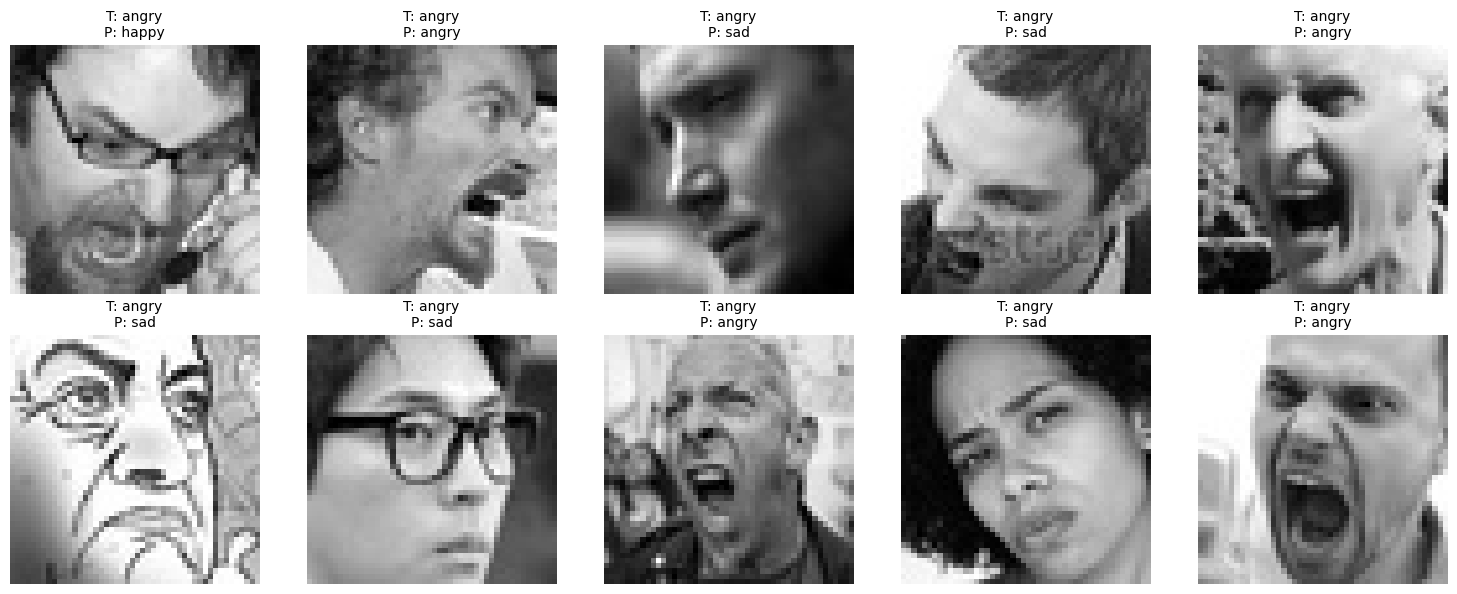

In [ ]:
# =================== DỰ ĐOÁN 10 ẢNH ====================

data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images[:10])
    _, preds = torch.max(outputs, 1)

# Plot ảnh + nhãn
plt.figure(figsize=(15, 6))
for i in range(10):
    img = images[i].cpu().permute(1, 2, 0).squeeze()
    true_label = class_names[labels[i].item()]
    pred_label = class_names[preds[i].item()]

    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# fine-tuning

đổi optimizer

In [14]:
# Khởi tạo lại mô hình
# Bước 1: Class weights cho 7 lớp (chèn 0.0 cho lớp 'disgust' nếu không có dữ liệu)
class_weights_dict = {
    'angry': 1.1795160617438465,
    'disgust': 1e-6,
    'fear': 1.1501505166381905,
    'happy': 0.6531069531069531,
    'sad': 0.9756038647342995,
    'surprise': 1.486019131714496,
    'neutral': 0.9490768714333669
}

# Chuyển class weights thành tensor đúng thứ tự lớp
class_order = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
class_weights = [class_weights_dict[cls] for cls in class_order]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Đưa lên thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = class_weights_tensor.to(device)

# Bước 2: Khởi tạo mô hình
model = EmotionCNN().to(device)

# Bước 3: Loss function có class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Bước 4: Optimizer và Scheduler
optimizer = AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

model.load_state_dict(torch.load('/content/best_model_1.pt'))
print("✅ Model đã được load từ 'best_model.pt'")

✅ Model đã được load từ 'best_model.pt'


In [15]:
# Bước 5: Huấn luyện mô hình
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=50,
    patience=15,
    device=device,
    scheduler=scheduler,
    save_path='best_model_1.pt'
)

Epoch 1/50 | Train Loss: 0.6309, Acc: 0.6280 | Val Loss: 2.8862, Acc: 0.6619
Epoch 2/50 | Train Loss: 0.6304, Acc: 0.6273 | Val Loss: 2.9286, Acc: 0.6629
Epoch 3/50 | Train Loss: 0.6289, Acc: 0.6282 | Val Loss: 2.8788, Acc: 0.6675
Epoch 4/50 | Train Loss: 0.6299, Acc: 0.6254 | Val Loss: 2.8981, Acc: 0.6590
Epoch 5/50 | Train Loss: 0.6256, Acc: 0.6285 | Val Loss: 2.9295, Acc: 0.6720
Epoch 6/50 | Train Loss: 0.6216, Acc: 0.6299 | Val Loss: 2.8969, Acc: 0.6638
Epoch 7/50 | Train Loss: 0.6208, Acc: 0.6288 | Val Loss: 2.8929, Acc: 0.6742
Epoch 8/50 | Train Loss: 0.6140, Acc: 0.6329 | Val Loss: 2.9280, Acc: 0.6705
Epoch 9/50 | Train Loss: 0.6125, Acc: 0.6328 | Val Loss: 2.8981, Acc: 0.6731
Epoch 10/50 | Train Loss: 0.6090, Acc: 0.6319 | Val Loss: 2.8950, Acc: 0.6681
Epoch 11/50 | Train Loss: 0.6104, Acc: 0.6362 | Val Loss: 2.8502, Acc: 0.6711
Epoch 12/50 | Train Loss: 0.5996, Acc: 0.6366 | Val Loss: 2.8589, Acc: 0.6765
Epoch 13/50 | Train Loss: 0.6048, Acc: 0.6357 | Val Loss: 2.8690, Acc: 0.

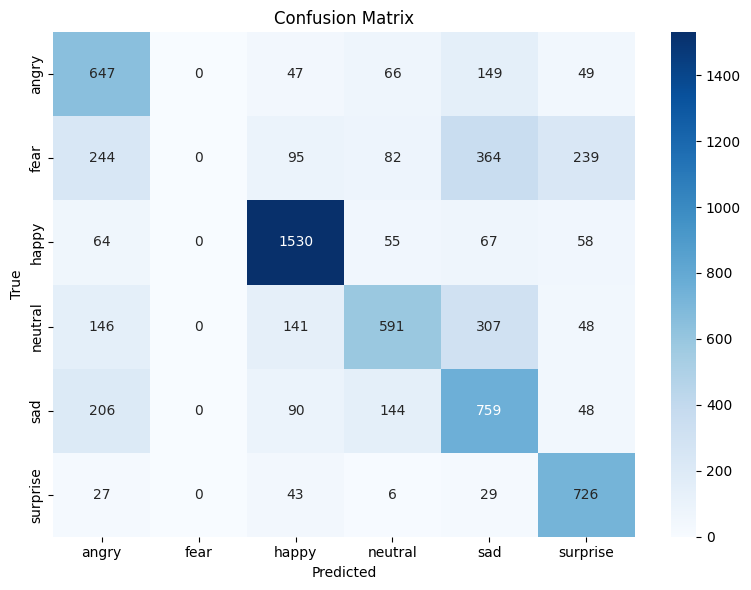

              precision    recall  f1-score   support

       angry       0.49      0.68      0.56       958
        fear       0.00      0.00      0.00      1024
       happy       0.79      0.86      0.82      1774
     neutral       0.63      0.48      0.54      1233
         sad       0.45      0.61      0.52      1247
    surprise       0.62      0.87      0.73       831

    accuracy                           0.60      7067
   macro avg       0.50      0.58      0.53      7067
weighted avg       0.53      0.60      0.55      7067



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# =================== ĐÁNH GIÁ ====================

# Load lại best model để đánh giá
model.load_state_dict(torch.load('/content/best_model_1.pt'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tên lớp
class_names = test_dataset.classes

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

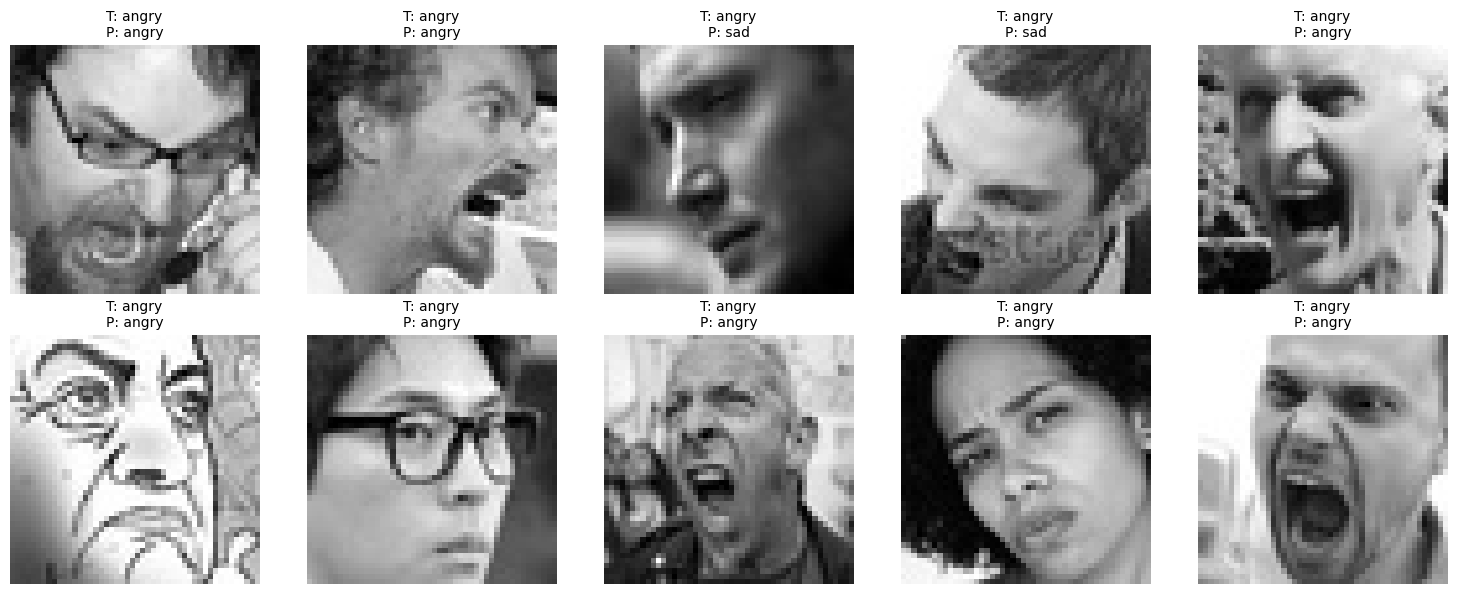

In [17]:
# =================== DỰ ĐOÁN 10 ẢNH ====================

data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images[:10])
    _, preds = torch.max(outputs, 1)

# Plot ảnh + nhãn
plt.figure(figsize=(15, 6))
for i in range(10):
    img = images[i].cpu().permute(1, 2, 0).squeeze()
    true_label = class_names[labels[i].item()]
    pred_label = class_names[preds[i].item()]

    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

đổi hàm loss

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

In [19]:
# Khởi tạo lại mô hình
# Bước 1: Class weights cho 7 lớp (chèn 0.0 cho lớp 'disgust' nếu không có dữ liệu)
class_weights_dict = {
    'angry': 1.1795160617438465,
    'disgust': 1e-6,
    'fear': 1.1501505166381905,
    'happy': 0.6531069531069531,
    'sad': 0.9756038647342995,
    'surprise': 1.486019131714496,
    'neutral': 0.9490768714333669
}

# Chuyển class weights thành tensor đúng thứ tự lớp
class_order = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
class_weights = [class_weights_dict[cls] for cls in class_order]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Đưa lên thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = class_weights_tensor.to(device)

# Bước 2: Khởi tạo mô hình
model = EmotionCNN().to(device)

# Bước 3: Loss function có class weights
criterion = FocalLoss(weight=class_weights_tensor)

# Bước 4: Optimizer và Scheduler
optimizer = AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

model.load_state_dict(torch.load('/content/best_model_1.pt'))
print("✅ Model đã được load từ 'best_model.pt'")

✅ Model đã được load từ 'best_model.pt'


In [20]:
# Bước 5: Huấn luyện mô hình
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=50,
    patience=15,
    device=device,
    scheduler=scheduler,
    save_path='best_model_1.pt'
)

Epoch 1/50 | Train Loss: 0.2841, Acc: 0.6338 | Val Loss: 0.2048, Acc: 0.6795
Epoch 2/50 | Train Loss: 0.2765, Acc: 0.6306 | Val Loss: 0.1967, Acc: 0.6778
Epoch 3/50 | Train Loss: 0.2688, Acc: 0.6326 | Val Loss: 0.1935, Acc: 0.6811
Epoch 4/50 | Train Loss: 0.2723, Acc: 0.6302 | Val Loss: 0.2026, Acc: 0.6571
Epoch 5/50 | Train Loss: 0.2641, Acc: 0.6344 | Val Loss: 0.1919, Acc: 0.6761
Epoch 6/50 | Train Loss: 0.2618, Acc: 0.6327 | Val Loss: 0.1893, Acc: 0.6765
Epoch 7/50 | Train Loss: 0.2605, Acc: 0.6345 | Val Loss: 0.1929, Acc: 0.6750
Epoch 8/50 | Train Loss: 0.2596, Acc: 0.6348 | Val Loss: 0.1888, Acc: 0.6828
Epoch 9/50 | Train Loss: 0.2574, Acc: 0.6349 | Val Loss: 0.1841, Acc: 0.6828
Epoch 10/50 | Train Loss: 0.2574, Acc: 0.6339 | Val Loss: 0.1855, Acc: 0.6810
Epoch 11/50 | Train Loss: 0.2496, Acc: 0.6377 | Val Loss: 0.1812, Acc: 0.6843
Epoch 12/50 | Train Loss: 0.2515, Acc: 0.6371 | Val Loss: 0.1826, Acc: 0.6793
Epoch 13/50 | Train Loss: 0.2487, Acc: 0.6385 | Val Loss: 0.1791, Acc: 0.

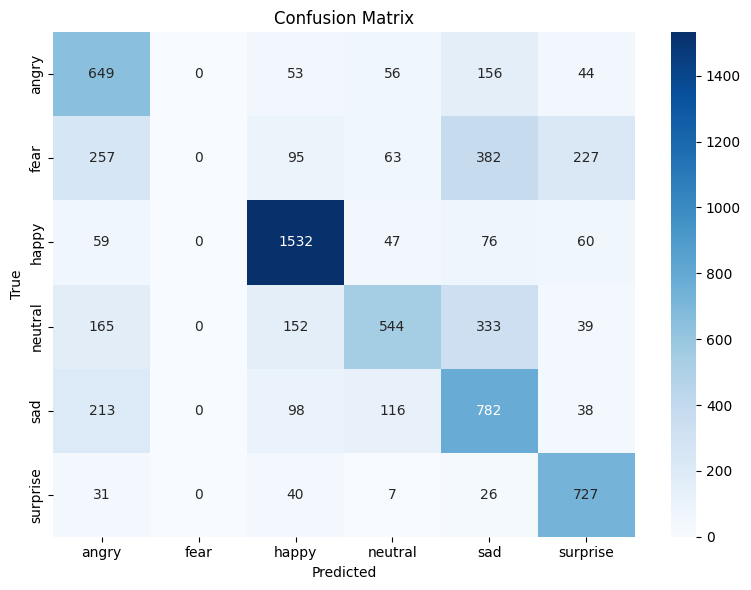

              precision    recall  f1-score   support

       angry       0.47      0.68      0.56       958
        fear       0.00      0.00      0.00      1024
       happy       0.78      0.86      0.82      1774
     neutral       0.65      0.44      0.53      1233
         sad       0.45      0.63      0.52      1247
    surprise       0.64      0.87      0.74       831

    accuracy                           0.60      7067
   macro avg       0.50      0.58      0.53      7067
weighted avg       0.53      0.60      0.55      7067



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# =================== ĐÁNH GIÁ ====================

# Load lại best model để đánh giá
model.load_state_dict(torch.load('/content/best_model_1.pt'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tên lớp
class_names = test_dataset.classes

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

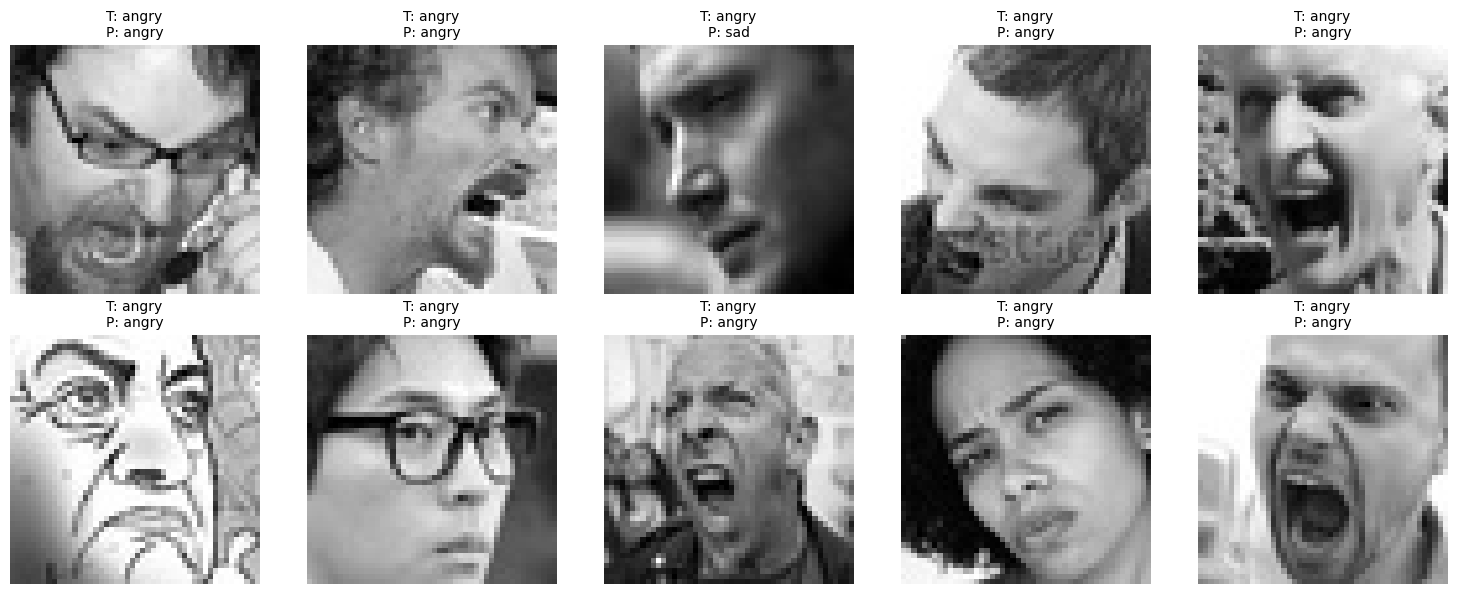

In [22]:
# =================== DỰ ĐOÁN 10 ẢNH ====================

data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images[:10])
    _, preds = torch.max(outputs, 1)

# Plot ảnh + nhãn
plt.figure(figsize=(15, 6))
for i in range(10):
    img = images[i].cpu().permute(1, 2, 0).squeeze()
    true_label = class_names[labels[i].item()]
    pred_label = class_names[preds[i].item()]

    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [29]:
# Danh sách cảm xúc theo đúng thứ tự mô hình
class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Transform như khi huấn luyện
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def predict_and_show_emotion(image_path, model, device='cuda'):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        pred = torch.argmax(output, dim=1).item()
        predicted_emotion = class_names[pred]

    # Hiển thị ảnh + dự đoán
    plt.imshow(img)
    plt.title(f"Predicted Emotion: {predicted_emotion}", fontsize=14)
    plt.axis('off')
    plt.show()

    return predicted_emotion

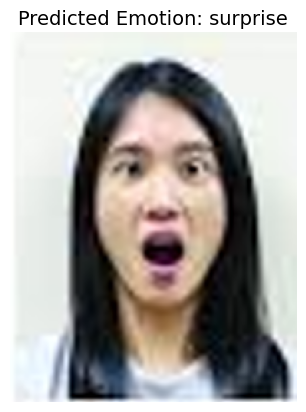

Dự đoán cảm xúc: surprise


In [31]:
emotion = predict_and_show_emotion("/content/Ảnh chụp màn hình 2025-04-09 120117.png", model)
print("Dự đoán cảm xúc:", emotion)